In [14]:
import os
import torch

ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/HeartRateRegression"
  from google.colab import drive
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_PATH = "/content/drive/My\ Drive/deeplearning_project/normalized.zip"
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git )
  ! (cd {REPO_DIR} && git pull )
  import sys
  sys.path.append(REPO_DIR)


def git_push():
  if os.name == 'nt':
    pass
  else:
    ! git config --global user.email "daviaguiar@outlook.com"
    ! git config --global user.name "Davi Pedrosa de Aguiar"
    print("going to push")
    ! (cd {REPO_DIR} && git pull && cd -)
    ! (cd {REPO_DIR} && git add . && git commit -m "from colab" && git push)

def git_pull():
  if os.name == 'nt':
    pass
  else:
    ! git config --global user.email "daviaguiar@outlook.com"
    ! git config --global user.name "Davi Pedrosa de Aguiar"
    print("going to push")
    ! (cd {REPO_DIR} && git pull && cd -)
    
  
git_push()


Windows


In [15]:
args = {
    'epoch_num': 250,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 0,     # Number of workers on data loader.
    'batch_size': 5,     # Mini-batch size. 600
    'batch_test': 248,     # size of test batch
    'window': 15,
    'initial_window':5,
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


In [16]:
import pandas as pd
! pip install wget 


from data_utils import Pamap2Handler


dataset_handler = Pamap2Handler(os.path.join(REPO_DIR, ".."))


dfs = [dataset_handler.get_protocol_subject(s) for s in [1,2,3,4,5,6,7,8]]
df_full = pd.concat(dfs)



You should consider upgrading via the 'c:\python37\python.exe -m pip install --upgrade pip' command.


In [17]:
from preprocessing_utils import (
    RecursiveHrMasker,
    LabelCumSum,
    LinearImputation,
    HZMeanSubstitute,
    DeltaHzToLabel,
    NormalizeDZ,
    LocalMeanReplacer,
    ZTransformer,
    ImputeZero,
    ActivityIdRelabeler,
    Downsampler,
    FeatureLabelSplit,
    TimeSnippetAggregator,
    RemoveLabels,
    SampleMaker,
    InitialStatePredictionSplit,
    TransformerPipeline
)


recursive_hr_masker = RecursiveHrMasker(0)

label_cum_sum = LabelCumSum()

hr_lin_imputation = LinearImputation("heart_rate")

meansub = HZMeanSubstitute()
deltahztolabel = DeltaHzToLabel()
normdz = NormalizeDZ()

local_mean_imputer = LocalMeanReplacer()
ztransformer = ZTransformer()
zero_imputer = ImputeZero()
activity_id_relabeler = ActivityIdRelabeler()
downsampler = Downsampler()
feature_label_splitter = FeatureLabelSplit(
    feature_columns = [
          'heart_rate', 'h_temperature', 'h_xacc16', 'h_yacc16', 'h_zacc16',
          'h_xacc6', 'h_yacc6', 'h_zacc6', 'h_xgyr', 'h_ygyr', 'h_zgyr', 'h_xmag',
          'h_ymag', 'h_zmag', 'c_temperature', 'c_xacc16', 'c_yacc16', 'c_zacc16',
          'c_xacc6', 'c_yacc6', 'c_zacc6', 'c_xgyr', 'c_ygyr', 'c_zgyr', 'c_xmag',
          'c_ymag', 'c_zmag', 'a_temperature', 'a_xacc16', 'a_yacc16', 'a_zacc16',
          'a_xacc6', 'a_yacc6', 'a_zacc6', 'a_xgyr', 'a_ygyr', 'a_zgyr', 'a_xmag',
          'a_ymag', 'a_zmag']
)
ts_aggregator = TimeSnippetAggregator(size=300)
label_remover = RemoveLabels([0])

ts_per_sample = 162#642#162# 642#322
ts_per_is = 2


sample_maker = SampleMaker(ts_per_sample, ts_per_sample//2)

sample_maker_ts = SampleMaker(ts_per_sample, ts_per_sample)

is_pred_split = InitialStatePredictionSplit(ts_per_sample, ts_per_is)

transformers = TransformerPipeline(ztransformer, hr_lin_imputation, local_mean_imputer,
                                   activity_id_relabeler,
                                   feature_label_splitter,
                                   ts_aggregator, meansub, deltahztolabel, normdz,
                                   sample_maker, label_cum_sum, is_pred_split, recursive_hr_masker)

transformers_ts = TransformerPipeline(ztransformer, hr_lin_imputation, local_mean_imputer,
                                   activity_id_relabeler,
                                   feature_label_splitter,
                                   ts_aggregator, meansub, deltahztolabel, normdz,
                                   sample_maker_ts, label_cum_sum, is_pred_split,recursive_hr_masker)


transformers.fit(df_full)

from data_utils import cross_validation_split



val_sub = 2


xy_tr, xy_val, xy_ts = cross_validation_split(dfs, transformers, transformers_ts, transformers_ts, val_sub,4)

# train_ts = [0,1,2,3,5,6,7] 

# val_idx = train_ts.index(val_sub)
# train_idxes = train_ts[:val_idx] + train_ts[val_idx+1:] 

# xy_tr = [transformers.transform(dfs[i]) for i in train_idxes]
# xy_val = [transformers_ts.transform(df) for df in dfs[4:5]]
# xy_ts = [transformers_ts.transform(dfs[i]) for i in [val_sub]]
# #xys_optional_t= [transformers.transform(df) for df in dfs_test]
# print(train_idxes)
# print(val_sub)



In [18]:
from models_utils import OurConvLstmDataset, make_loader, reset_seeds

reset_seeds()


loader_tr = make_loader(xy_tr, OurConvLstmDataset, batch_size=args["batch_size"], shuffle=True)
loader_val = make_loader(xy_val, OurConvLstmDataset, batch_size=args["batch_test"],shuffle=False)
loader_ts = make_loader(xy_ts, OurConvLstmDataset, batch_size=args["batch_test"], shuffle=False)


In [19]:
from default_utils import make_our_conv_lstm
from torch import nn

net = make_our_conv_lstm(40, 1).to(args["device"])
criterion = nn.L1Loss().to(args["device"]) 
optimizer = torch.optim.Adam(net.parameters(), lr=args["lr"],
                             weight_decay=args["weight_decay"])

In [20]:
from models_utils import get_n_params
  
get_n_params(net)

64097

In [21]:
class TrainOurConvLSTM():
    def __init__(
            self,
            net,
            criterion,
            optimizer,
            loader_tr,
            loader_val,
            normdz,
            ztransformer,
            device
            ):
        
        self.net = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.loader_tr = loader_tr
        self.loader_val = loader_val
        self.normdz = normdz
        self.ztransformer = ztransformer
        self.device = device
                 

    def inverse_transform_label(self, yis, yrs):
        _, inverse_delta_y = self.normdz.reverse_transform((None,yrs))

        last_y = yis[:, -1]

        ys = inverse_delta_y.reshape(inverse_delta_y.shape[:2]) + last_y

        ymean = self.ztransformer.transformer.mean_[0] 
        ystd = self.ztransformer.transformer.var_[0]**0.5

        inverse_ys = (ys*ystd)+ymean
        return inverse_ys


    def plot_predictions(self, yi, yp, predictions, print_indices = [0]):
        yi = yi.detach().cpu().numpy()
        yp = yp.detach().cpu().numpy()
        p = predictions.detach().cpu().numpy()

        yr = self.inverse_transform_label(yi,yp)
        pr = self.inverse_transform_label(yi,p)

        for i in print_indices:
            plt.figure()
            plt.plot(np.linspace(1,3*yr.shape[1]-1, yr.shape[1]), yr[i], 'b', label="label")
            plt.plot(np.linspace(1,3*yr.shape[1]-1, yr.shape[1]), pr[i], 'k', label="predictions")
            plt.xlabel("seconds")
            plt.legend()
            plt.show()

    def plot_prediction(self, yi, yp, predictions, print_index = 0):
        yi = yi.detach().cpu().numpy()
        yp = yp.detach().cpu().numpy()
        p = predictions.detach().cpu().numpy()

        yr = self.inverse_transform_label(yi,yp)
        pr = self.inverse_transform_label(yi,p)

        i = print_index
        fig = plt.figure()
        plt.plot(np.linspace(1,3*yr.shape[1]-1, yr.shape[1]), yr[i], 'b', label="label")
        plt.plot(np.linspace(1,3*yr.shape[1]-1, yr.shape[1]), pr[i], 'k', label="predictions")
        plt.xlabel("seconds")
        plt.legend()
        return fig 

    def plot_heart_rate(self, loader, indices=[0,]):
        batch = loader.__iter__().__next__()
        self.net.eval()
        xi, yi, xp, yp = map(lambda v: v.to(self.device), batch)
        self.plot_predictions(yi,yp, self.net(xi,yi,xp), indices)


    def plot_single_heart_rate(self, loader, index):
        batch = loader.__iter__().__next__()
        self.net.eval()
        xi, yi, xp, yp = map(lambda v: v.to(self.device), batch)
        return self.plot_prediction(yi,yp, self.net(xi,yi,xp), index)


    def HR_MAE(self, yi,yp, predictions):
        yi = yi.detach().cpu().numpy()
        yp = yp.detach().cpu().numpy()
        p = predictions.detach().cpu().numpy()

        yr = self.inverse_transform_label(yi,yp)
        pr = self.inverse_transform_label(yi,p)

        return np.abs(yr-pr).mean()


    def HR_RMSE(self, yi, yp, predictions):
        yi = yi.detach().cpu().numpy()
        yp = yp.detach().cpu().numpy()
        p = predictions.detach().cpu().numpy()

        yr = self.inverse_transform_label(yi,yp)
        pr = self.inverse_transform_label(yi,p)

        return (((yr-pr)**2).mean())**0.5



    def train(self, batch):
        self.net.train()
        xi,yi,xr, yr = map(lambda v: v.to(self.device), batch)
        self.net.zero_grad()

        p = self.net(xi,yi,xr)
        loss = self.criterion(p, yr)
        
        loss.backward()
        self.optimizer.step()
        return loss.cpu().item()

    def validate(self):
        self.net.eval()
        losses = list()
        for batch in self.loader_val:
            self.net.eval()
            xi,yi,xr,yr = map(lambda v: v.to(self.device), batch)
            p = self.net(xi,yi,xr)
            loss = self.criterion(p, yr)
            losses.append(loss.cpu().item())
        
        return torch.mean(torch.FloatTensor(losses))
        
    #mae_criterion = nn.L1Loss()

    def get_data_epoch(self, loader):
        self.net.eval()
        xis, yis, xrs, yrs, ps = [],[],[],[],[]
        with torch.no_grad():
            for batch in loader:
                xi,yi,xr,yr = map(lambda v: v.to(self.device), batch)
                p = self.net(xi, yi, xr)
                xis.append(xi.detach().cpu())
                xrs.append(xr.detach().cpu())
                yis.append(yi.detach().cpu())
                yrs.append(yr.detach().cpu())
                ps.append(p.detach().cpu())
        
        return torch.cat(xis), torch.cat(yis), torch.cat(xrs), torch.cat(yrs), torch.cat(ps)

    def compute_batch_MAE(self, batch):
        self.net.eval()
        xi,yi,xr,yr = map(lambda v: v.to(self.device), batch)
        return self.HR_MAE(yi,yr, self.net(xi,yi,xr)) 
        
    
    def compute_mean_MAE(self, loader):
        xi, yi, xr, yr, p = self.get_data_epoch(loader)
        return self.HR_MAE(yi, yr, p)
    


    def train_epochs(self, epochs_count):
        best_val_model = copy.deepcopy(self.net.state_dict()) 
        train_losses = list()
        train_accuracies = list()
        validation_losses = list()
        validation_accuracies = list()
        test_accuracies = list()

        validation_losses.append(self.compute_mean_MAE(self.loader_val))

        for epoch in range(1, n_epoch+1):           
            losses = []
            for batch_idx, batch in enumerate(self.loader_tr):
                losses.append(self.train(batch))

            val_loss = self.compute_mean_MAE(loader_val) 
            if val_loss < np.min(validation_losses):
                print("best val epoch:", epoch)
                best_val_model = copy.deepcopy(self.net.state_dict()) 

            train_losses.append(torch.mean(torch.FloatTensor(losses)) )
            validation_losses.append(val_loss)
            train_accuracies.append(self.compute_mean_MAE(loader_tr))
            validation_accuracies.append(val_loss)
            test_accuracies.append(self.compute_mean_MAE(loader_ts))   
            print('[%d/%d]: loss_train: %.3f loss_val %.3f loss_ts %.3f' % (
                    (epoch), n_epoch, train_accuracies[-1],
                    validation_accuracies[-1], test_accuracies[-1]))
            
            if (epoch % 10) == 0:
                print("Test")
                self.plot_heart_rate(loader_ts)
                print("Validation")
                self.plot_heart_rate(loader_val)
                print("Train")
                self.plot_heart_rate(loader_tr)
                self.compute_mean_MAE(loader_ts)

            return {
                "best_val_model": best_val_model,
                "train_mae": train_losses,
                "validation_mae": train_accuracies,
                "test_mae": test_accuracies
            }

In [30]:
#from default_utils import TrainOurConvLSTM  
import copy
import matplotlib.pyplot as plt

class TrainOurConvLSTM():
    def __init__(
            self,
            net,
            criterion,
            optimizer,
            loader_tr,
            loader_val,
            loader_ts,
            normdz,
            ztransformer,
            device
            ):
        
        self.net = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.loader_tr = loader_tr
        self.loader_val = loader_val
        self.loader_ts = loader_ts
        self.normdz = normdz
        self.ztransformer = ztransformer
        self.device = device
                 

    def inverse_transform_label(self, yis, yrs):
        _, inverse_delta_y = self.normdz.reverse_transform((None,yrs))

        last_y = yis[:, -1]

        ys = inverse_delta_y.reshape(inverse_delta_y.shape[:2]) + last_y

        ymean = self.ztransformer.transformer.mean_[0] 
        ystd = self.ztransformer.transformer.var_[0]**0.5

        inverse_ys = (ys*ystd)+ymean
        return inverse_ys


    def plot_predictions(self, yi, yp, predictions, print_indices = [0]):
        yi = yi.detach().cpu().numpy()
        yp = yp.detach().cpu().numpy()
        p = predictions.detach().cpu().numpy()

        yr = self.inverse_transform_label(yi,yp)
        pr = self.inverse_transform_label(yi,p)

        for i in print_indices:
            plt.figure()
            plt.plot(np.linspace(1,3*yr.shape[1]-1, yr.shape[1]), yr[i], 'b', label="label")
            plt.plot(np.linspace(1,3*yr.shape[1]-1, yr.shape[1]), pr[i], 'k', label="predictions")
            plt.xlabel("seconds")
            plt.legend()
            plt.show()

    def plot_prediction(self, yi, yp, predictions, print_index = 0):
        yi = yi.detach().cpu().numpy()
        yp = yp.detach().cpu().numpy()
        p = predictions.detach().cpu().numpy()

        yr = self.inverse_transform_label(yi,yp)
        pr = self.inverse_transform_label(yi,p)

        i = print_index
        fig = plt.figure()
        plt.plot(np.linspace(1,3*yr.shape[1]-1, yr.shape[1]), yr[i], 'b', label="label")
        plt.plot(np.linspace(1,3*yr.shape[1]-1, yr.shape[1]), pr[i], 'k', label="predictions")
        plt.xlabel("seconds")
        plt.legend()
        return fig 

    def plot_heart_rate(self, loader, indices=[0,]):
        batch = loader.__iter__().__next__()
        self.net.eval()
        xi, yi, xp, yp = map(lambda v: v.to(self.device), batch)
        self.plot_predictions(yi,yp, self.net(xi,yi,xp), indices)


    def plot_single_heart_rate(self, loader, index):
        batch = loader.__iter__().__next__()
        self.net.eval()
        xi, yi, xp, yp = map(lambda v: v.to(self.device), batch)
        return self.plot_prediction(yi,yp, self.net(xi,yi,xp), index)


    def HR_MAE(self, yi,yp, predictions):
        yi = yi.detach().cpu().numpy()
        yp = yp.detach().cpu().numpy()
        p = predictions.detach().cpu().numpy()

        yr = self.inverse_transform_label(yi,yp)
        pr = self.inverse_transform_label(yi,p)

        return np.abs(yr-pr).mean()


    def HR_RMSE(self, yi, yp, predictions):
        yi = yi.detach().cpu().numpy()
        yp = yp.detach().cpu().numpy()
        p = predictions.detach().cpu().numpy()

        yr = self.inverse_transform_label(yi,yp)
        pr = self.inverse_transform_label(yi,p)

        return (((yr-pr)**2).mean())**0.5



    def train(self, batch):
        self.net.train()
        xi,yi,xr, yr = map(lambda v: v.to(self.device), batch)
        self.net.zero_grad()

        p = self.net(xi,yi,xr)
        loss = self.criterion(p, yr)
        
        loss.backward()
        self.optimizer.step()
        return loss.cpu().item()

    def validate(self):
        self.net.eval()
        losses = list()
        for batch in self.loader_val:
            self.net.eval()
            xi,yi,xr,yr = map(lambda v: v.to(self.device), batch)
            p = self.net(xi,yi,xr)
            loss = self.criterion(p, yr)
            losses.append(loss.cpu().item())
        
        return torch.mean(torch.FloatTensor(losses))
        
    #mae_criterion = nn.L1Loss()

    def get_data_epoch(self, loader):
        self.net.eval()
        xis, yis, xrs, yrs, ps = [],[],[],[],[]
        with torch.no_grad():
            for batch in loader:
                xi,yi,xr,yr = map(lambda v: v.to(self.device), batch)
                p = self.net(xi, yi, xr)
                xis.append(xi.detach().cpu())
                xrs.append(xr.detach().cpu())
                yis.append(yi.detach().cpu())
                yrs.append(yr.detach().cpu())
                ps.append(p.detach().cpu())
        
        return torch.cat(xis), torch.cat(yis), torch.cat(xrs), torch.cat(yrs), torch.cat(ps)

    def compute_batch_MAE(self, batch):
        self.net.eval()
        xi,yi,xr,yr = map(lambda v: v.to(self.device), batch)
        return self.HR_MAE(yi,yr, self.net(xi,yi,xr)) 
        
    
    def compute_mean_MAE(self, loader):
        xi, yi, xr, yr, p = self.get_data_epoch(loader)
        return self.HR_MAE(yi, yr, p)
    


    def train_epochs(self, n_epoch):
        best_val_model = copy.deepcopy(self.net.state_dict()) 
        train_losses = list()
        train_accuracies = list()
        validation_losses = list()
        validation_accuracies = list()
        test_accuracies = list()

        validation_losses.append(self.compute_mean_MAE(self.loader_val))

        for epoch in range(1, n_epoch+1):           
            losses = []
            for batch_idx, batch in enumerate(self.loader_tr):
                losses.append(self.train(batch))

            val_loss = self.compute_mean_MAE(self.loader_val) 
            if val_loss < np.min(validation_losses):
                print("best val epoch:", epoch)
                best_val_model = copy.deepcopy(self.net.state_dict()) 

            train_losses.append(torch.mean(torch.FloatTensor(losses)) )
            validation_losses.append(val_loss)
            train_accuracies.append(self.compute_mean_MAE(self.loader_tr))
            validation_accuracies.append(val_loss)
            test_accuracies.append(self.compute_mean_MAE(self.loader_ts))   
            print('[%d/%d]: loss_train: %.3f loss_val %.3f loss_ts %.3f' % (
                    (epoch), n_epoch, train_accuracies[-1],
                    validation_accuracies[-1], test_accuracies[-1]))
            
            if (epoch % 10) == 0:
                print("Test")
                self.plot_heart_rate(self.loader_ts)
                print("Validation")
                self.plot_heart_rate(self.loader_val)
                print("Train")
                self.plot_heart_rate(self.loader_tr)
                self.compute_mean_MAE(self.loader_ts)

        return {
            "best_val_model": best_val_model,
            "train_mae": train_losses,
            "validation_mae": train_accuracies,
            "test_mae": test_accuracies
        }

Test


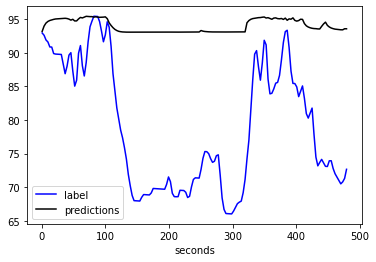

Validation


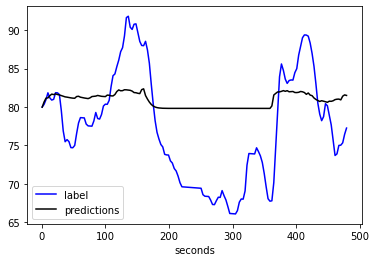

Train


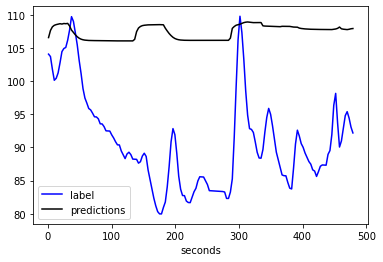

(13.602067, 13.350156, 12.117291, tensor(7.2193))

In [31]:


trainer = TrainOurConvLSTM(
        net,
        criterion,
        optimizer,
        loader_tr,
        loader_val,
        loader_ts,
        normdz,
        ztransformer,
        device = args["device"]
)

print("Test")
trainer.plot_heart_rate(loader_ts)
print("Validation")
trainer.plot_heart_rate(loader_val)
print("Train")
trainer.plot_heart_rate(loader_tr)
trainer.compute_mean_MAE(loader_tr), trainer.compute_mean_MAE(loader_ts), trainer.compute_mean_MAE(loader_val), trainer.validate()


#trainer.HR_MAE(x,y,p), trainer.HR_RMSE(x,y,p)


In [29]:
%%time
import numpy as np

import copy

run_output = trainer.train_epochs(args["epoch_num"])
# best_val_model = copy.deepcopy(net.state_dict()) 

# n_epoch = args["epoch_num"]
# train_losses = list()
# train_accuracies = list()
# validation_losses = list()
# validation_accuracies = list()
# test_accuracies = list()

# validation_losses.append(trainer.compute_mean_MAE(loader_val))

# for epoch in range(1, n_epoch+1):           
#     losses = []
#     for batch_idx, batch in enumerate(loader_tr):
#         losses.append(trainer.train(batch))

#     val_loss = trainer.compute_mean_MAE(loader_val) 
#     if val_loss < np.min(validation_losses):
#       print("best val epoch:", epoch)
#       best_val_model = copy.deepcopy(trainer.net.state_dict()) 

#     train_losses.append(torch.mean(torch.FloatTensor(losses)) )
#     validation_losses.append(val_loss)
#     train_accuracies.append(trainer.compute_mean_MAE(loader_tr))
#     validation_accuracies.append(val_loss)
#     test_accuracies.append(trainer.compute_mean_MAE(loader_ts))   
#     print('[%d/%d]: loss_train: %.3f loss_val %.3f loss_ts %.3f' % (
#             (epoch), n_epoch, train_accuracies[-1],
#             validation_accuracies[-1], test_accuracies[-1]))
    
#     if (epoch % 10) == 0:
#       print("Test")
#       trainer.plot_heart_rate(loader_ts)
#       print("Validation")
#       trainer.plot_heart_rate(loader_val)
#       print("Train")
#       trainer.plot_heart_rate(loader_tr)
#       trainer.compute_mean_MAE(loader_ts)

# 3


[1/250]: loss_train: 13.602 loss_val 12.117 loss_ts 13.350
Wall time: 1min 6s
